# Privacy Assignment 1: Attacks

### Setup

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPool2D
from sklearn.model_selection import StratifiedShuffleSplit

# Configure libraries for CIFAR10
from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

root_dir = "/content/drive/My Drive/"
project_dir = "Assignment3" # Change to your path
os.chdir(root_dir + project_dir)

!ls

Mounted at /content/drive
attacking_mlaas_data.npz	      privacy_assignment_1.ipynb
input_reconstruction_challenge_model


## 1. Warm-up

In [3]:
def cnn_classifier(input_shape, num_classes):
    model = tf.keras.models.Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [4]:
class Cifar10Dataset:
    def __init__(self):
        self.input_shape = (32, 32, 3)
        self.num_classes = 10
        self.class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
        self.x_train, self.y_train, self.x_test, self.y_test = self.preprocess_cifar10_for_cnn()

    def shuffle_and_sample(self, x, y, num_samples, seed):
        stratified_splitter = StratifiedShuffleSplit(n_splits=1,
                                                     train_size=num_samples,
                                                     test_size=100,
                                                     random_state=seed)

        for indices, _ in stratified_splitter.split(x, y):
            return x[indices], y[indices]

    def preprocess_cifar10_for_cnn(self):
        num_classes = 10

        # Split the data between train and test sets
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

        # TODO: Uncomment these lines and scale images to the [0, 1] range
        x_train = x_train.astype("float32") / 255
        x_test = x_test.astype("float32") / 255

        # TODO: Uncomment these lines and convert labels into one hot vectors
        y_train = tf.one_hot(y_train.squeeze(), num_classes, dtype=tf.int32).numpy()
        y_test = tf.one_hot(y_test.squeeze(), num_classes, dtype=tf.int32).numpy()

        return x_train, y_train, x_test, y_test

    def get_stratified_train_test_split(self, num_train_data, num_test_data, seed):
        x_train, y_train = self.shuffle_and_sample(self.x_train,
                                                   self.y_train,
                                                   num_samples=num_train_data,
                                                   seed=seed)
        x_test, y_test = self.shuffle_and_sample(self.x_test,
                                                 self.y_test,
                                                 num_samples=num_test_data,
                                                 seed=seed)

        return x_train, y_train, x_test, y_test

    def plot_images(self, x, y):
        plt.figure(figsize=(10,10))
        for i in range(25):
            plt.subplot(5,5,i+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(x[i])
            plt.xlabel(self.class_names[np.argmax(y[i])])
        plt.show()

In [5]:
class HyperParams:
    def __init__(self, loss_fn, optim_fn, batch_size, epochs, validation_split):
        self.loss_fn = loss_fn
        self.optim_fn = optim_fn
        self.batch_size = batch_size
        self.epochs = epochs
        self.validation_split = validation_split

In [6]:
def get_trained_model_on_cifar10(model, x_train, y_train, hyperparams: HyperParams):
    # initialize model
    model.compile(loss=hyperparams.loss_fn, optimizer=hyperparams.optim_fn, metrics=['accuracy'])

    # TODO: return model and training history (history is returned by the model.fit() call)
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=hyperparams.batch_size,
        epochs=hyperparams.epochs,
        validation_split=hyperparams.validation_split
      )

    return model, history

In [7]:
cifar10dataset = Cifar10Dataset()
num_train_data = 2000
num_test_data = 2000
seed = 123
x_train, y_train, x_test, y_test = cifar10dataset.get_stratified_train_test_split(num_train_data,
                                                                                  num_test_data,
                                                                                  seed)

170498071/170498071 [==============================] - 6s 0us/step


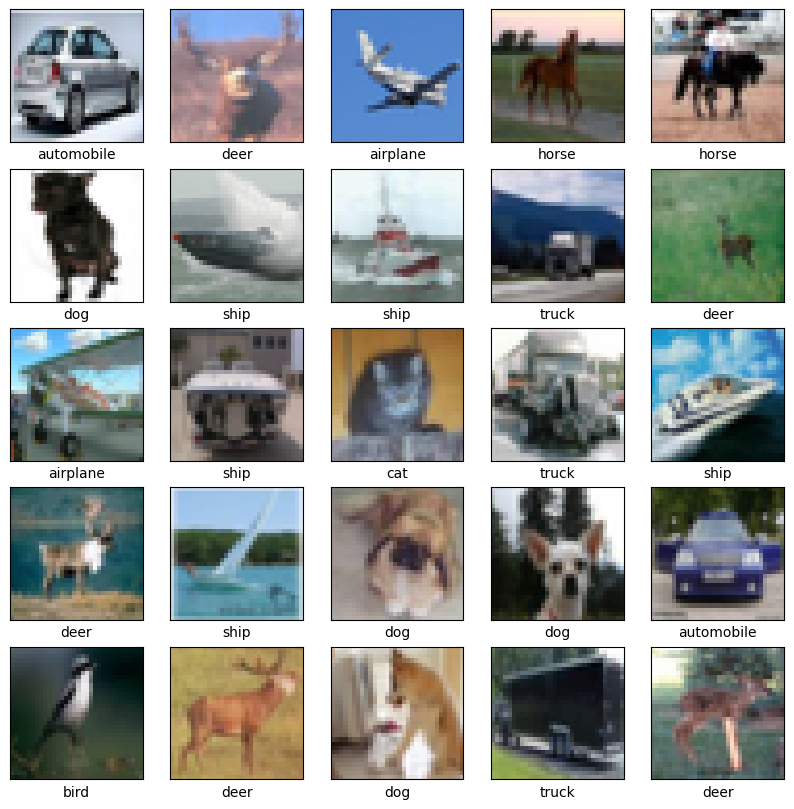

In [8]:
cifar10dataset.plot_images(x_train, y_train)

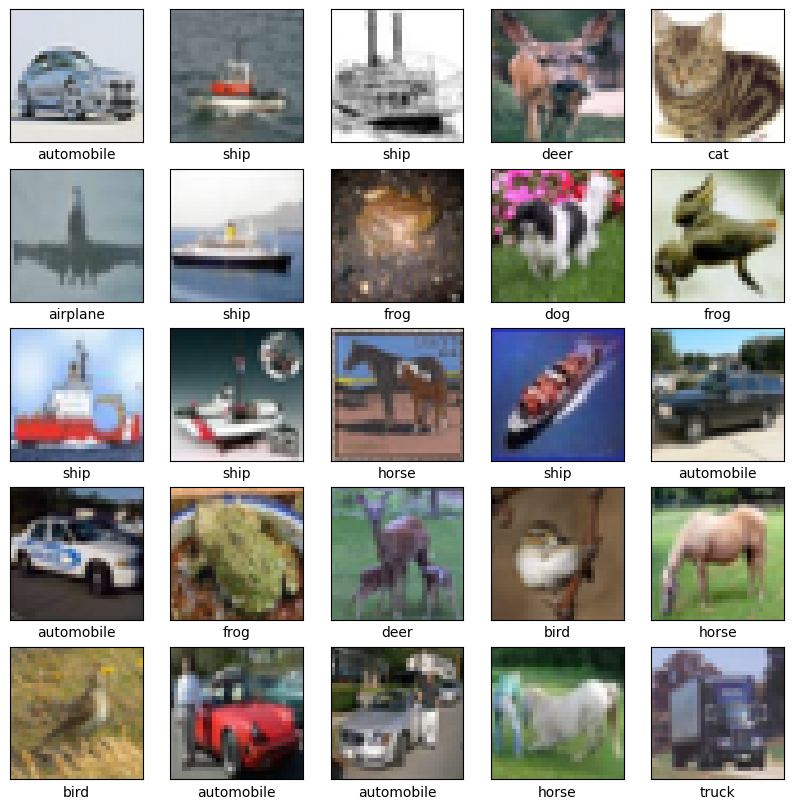

In [9]:
cifar10dataset.plot_images(x_test, y_test)

In [10]:
loss_fn = 'categorical_crossentropy'

learning_rate = 0.1
optim_fn = tf.keras.optimizers.SGD(learning_rate)

batch_size = 64
epochs = 50
validation_split = 0.25
hyperparams = HyperParams(loss_fn, optim_fn, batch_size, epochs, validation_split)

model = cnn_classifier(cifar10dataset.input_shape, cifar10dataset.num_classes)
model, history = get_trained_model_on_cifar10(model, x_train, y_train, hyperparams)

Epoch 1/50
24/24 [==============================] - 12s 23ms/step - loss: 2.3062 - accuracy: 0.1180 - val_loss: 2.2917 - val_accuracy: 0.0800
Epoch 2/50
24/24 [==============================] - 0s 6ms/step - loss: 2.2599 - accuracy: 0.1447 - val_loss: 2.2208 - val_accuracy: 0.2080
Epoch 3/50
24/24 [==============================] - 0s 7ms/step - loss: 2.2055 - accuracy: 0.1913 - val_loss: 2.2882 - val_accuracy: 0.0980
Epoch 4/50
24/24 [==============================] - 0s 6ms/step - loss: 2.1800 - accuracy: 0.2033 - val_loss: 2.1573 - val_accuracy: 0.2280
Epoch 5/50
24/24 [==============================] - 0s 6ms/step - loss: 2.1455 - accuracy: 0.2280 - val_loss: 2.1174 - val_accuracy: 0.2200
Epoch 6/50
24/24 [==============================] - 0s 8ms/step - loss: 2.0885 - accuracy: 0.2533 - val_loss: 2.5574 - val_accuracy: 0.1300
Epoch 7/50
24/24 [==============================] - 0s 6ms/step - loss: 2.1266 - accuracy: 0.2507 - val_loss: 2.0228 - val_accuracy: 0.2780
Epoch 8/50
24/24 [

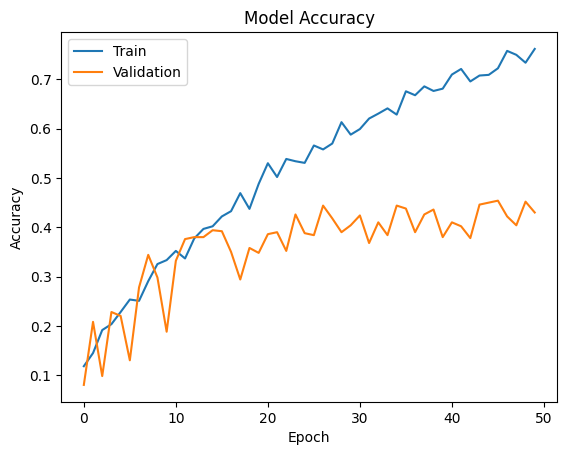

In [11]:
# Plot train and validation accuracy per epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

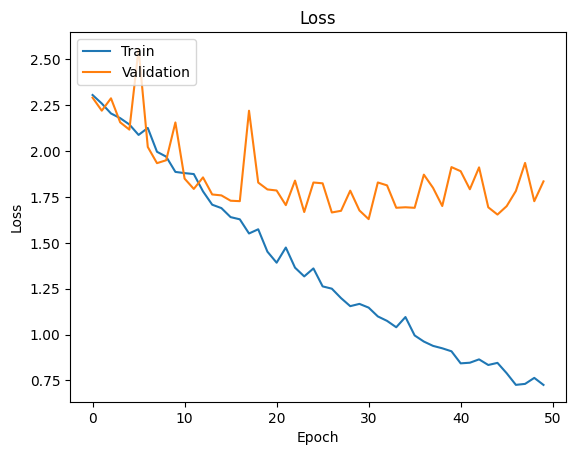

In [12]:
# Plot train and validation loss per epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [13]:
# TODO: get train and test loss, acc
train_loss, train_acc = history.history['loss'][-1], history.history['accuracy'][-1]
print(f"Loss on train set: {train_loss}")
print(f"Accuracy on train set: {train_acc}")

test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Loss on test set: {test_loss}")
print(f"Accuracy on test set: {test_acc}")

Loss on train set: 0.725408673286438
Accuracy on train set: 0.7620000243186951
63/63 [==============================] - 0s 5ms/step - loss: 1.8662 - accuracy: 0.4280
Loss on test set: 1.8662265539169312
Accuracy on test set: 0.42800000309944153


In [14]:
def generate_true_membership_labels(train_data, test_data):
    true_members = [1] * len(train_data) # members take label '1'
    true_non_members = [0] * len(test_data) # non-members take label '0'
    y_true = true_members
    y_true.extend(true_non_members)

    return y_true

In [15]:
from sklearn.metrics import confusion_matrix

def naive_membership_inference_attack(model, x_train, y_train, x_test, y_test):
    train_logits = np.array(model(x_train))
    test_logits = np.array(model(x_test))

    # TODO: generate the membership labels on the train data
    train_pred_labels = [np.argmax(t) for t in train_logits]
    train_pred_labels = tf.one_hot(train_pred_labels, 10, dtype=tf.int32).numpy()
    pred_members = [1 if (pred == true).all() else 0 for (pred, true) in zip(train_pred_labels, y_train)]

    # TODO: generate the membership labels on the test data
    test_pred_labels = [np.argmax(t) for t in test_logits]
    test_pred_labels = tf.one_hot(test_pred_labels, 10, dtype=tf.int32).numpy()
    pred_non_members = [1 if (pred == true).all() else 0 for (pred, true) in zip(test_pred_labels, y_test)]

    y_pred = pred_members
    y_pred.extend(pred_non_members)

    y_true = generate_true_membership_labels(y_train, y_test)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    print(f"True Positive: {tp} \nTrue Negative: {tn} \nFalse Positive: {fp} \nFalse Negative: {fn}")
    print(f"Attack accuracy of the naive membership inference attack: {(tp + tn)/(tn + fp + fn + tp)}")

naive_membership_inference_attack(model, x_train, y_train, x_test, y_test)

True Positive: 1484 
True Negative: 1144 
False Positive: 856 
False Negative: 516
Attack accuracy of the naive membership inference attack: 0.657


## 2. Membership Inference Attacks Using Loss Values

In [15]:
def plot_loss_histogram(train_losses, test_losses, caption):
    # TODO: complete this function to plot
    # histogram for train and test losses
    plt.hist(train_losses, label='Train Loss', bins=25)
    plt.hist(test_losses, label='Test Loss', alpha=0.7, bins=25)
    plt.legend()
    plt.xlabel('Loss')
    plt.ylabel('No. of data points')
    plt.title(caption)
    plt.show()
    return

In [16]:
def plot_attack_accuracies(accuracies, loss_thresholds):
    plt.plot(loss_thresholds, accuracies)
    plt.xlabel('Loss Threshold')
    plt.ylabel('Attack accuracy')
    plt.show()
    return

In [26]:
def estimate_threshold(train_losses, test_losses, loss_thresholds, y_train, y_test, plot=False):
  loss_threshold = None
  max_accuracy = float('-inf')
  accuracies = []

  for lt in loss_thresholds:
    # TODO: generate the membership labels on the train data
    pred_members = [1 if t < lt else 0 for t in train_losses]

    # TODO: generate the membership labels on the test data
    pred_non_members = [1 if t < lt else 0 for t in test_losses]

    y_pred = pred_members
    y_pred.extend(pred_non_members)

    y_true = generate_true_membership_labels(y_train, y_test)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    accuracy = (tp + tn)/(tn + fp + fn + tp)
    accuracies.append(accuracy)
    if accuracy > max_accuracy:
      max_accuracy = accuracy
      loss_threshold = lt

  if plot:
    plot_attack_accuracies(accuracies, loss_thresholds)
  return loss_threshold

### 2.1. Using Loss Values to Estimate a Single Threshold

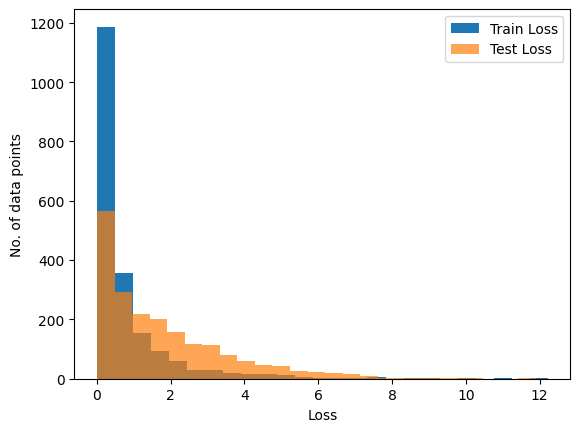

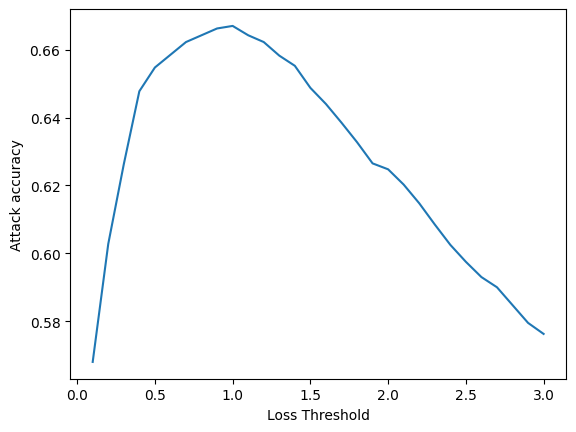

Attack accuracy of the loss membership inference attack: 0.667 with loss threshold: 1.0


In [23]:
def loss_membership_inference_attack(model, loss_obj, x_train, y_train, x_test, y_test):
    train_logits = model(x_train)
    train_losses = loss_obj(y_true=y_train, y_pred=train_logits)

    test_logits = model(x_test)
    test_losses = loss_obj(y_true=y_test, y_pred=test_logits)

    # TODO: plot the loss histogram
    plot_loss_histogram(train_losses, test_losses, caption='')

    # TODO: estimate the loss threshold
    loss_thresholds = [0.1*x for x in range(1, 31)]
    loss_threshold = estimate_threshold(
        train_losses,
        test_losses,
        loss_thresholds,
        y_train,
        y_test,
        plot=True
      )

    # TODO: generate the membership labels on the train data
    pred_members = [1 if t < loss_threshold else 0 for t in train_losses]

    # TODO: generate the membership labels on the test data
    pred_non_members = [1 if t < loss_threshold else 0 for t in test_losses]

    y_pred = pred_members
    y_pred.extend(pred_non_members)

    y_true = generate_true_membership_labels(y_train, y_test)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(f"Attack accuracy of the loss membership inference attack: {(tp + tn)/(tn + fp + fn + tp)} with loss threshold: {loss_threshold}")

loss_obj = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE, from_logits=False)
loss_membership_inference_attack(model, loss_obj, x_train, y_train, x_test, y_test)

### 2.2. Using Loss Values to Estimate a Threshold for Each Class

Bucketing class 0...
Bucketing class 1...
Bucketing class 2...
Bucketing class 3...
Bucketing class 4...
Bucketing class 5...
Bucketing class 6...
Bucketing class 7...
Bucketing class 8...
Bucketing class 9...
Bucketing class 0...
Bucketing class 1...
Bucketing class 2...
Bucketing class 3...
Bucketing class 4...
Bucketing class 5...
Bucketing class 6...
Bucketing class 7...
Bucketing class 8...
Bucketing class 9...


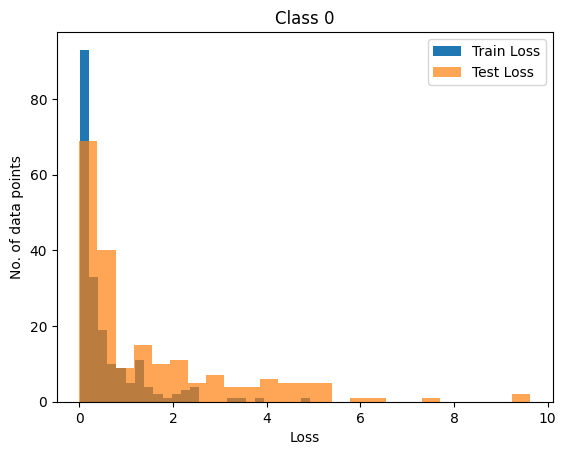

Attack accuracy of the loss membership inference attack for class 0: 0.64


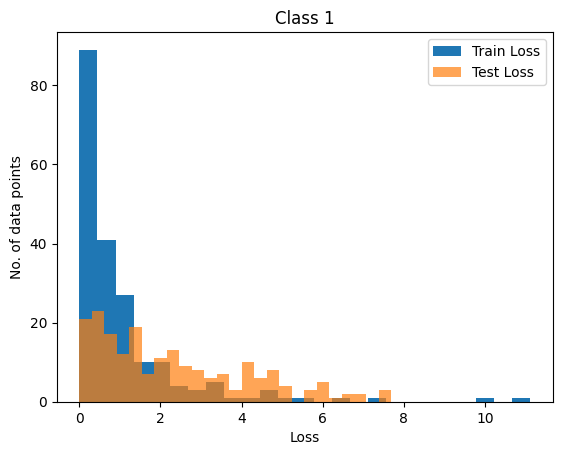

Attack accuracy of the loss membership inference attack for class 1: 0.7


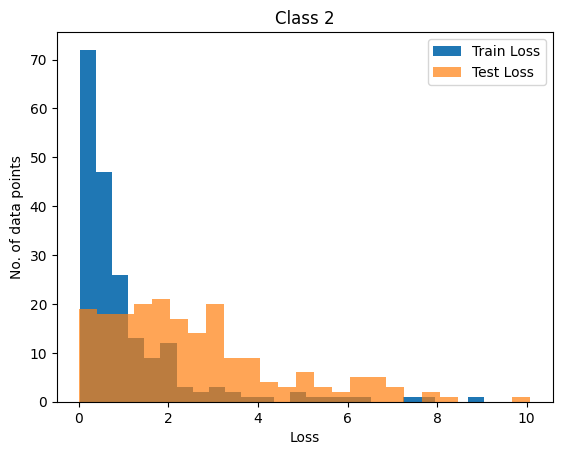

Attack accuracy of the loss membership inference attack for class 2: 0.745


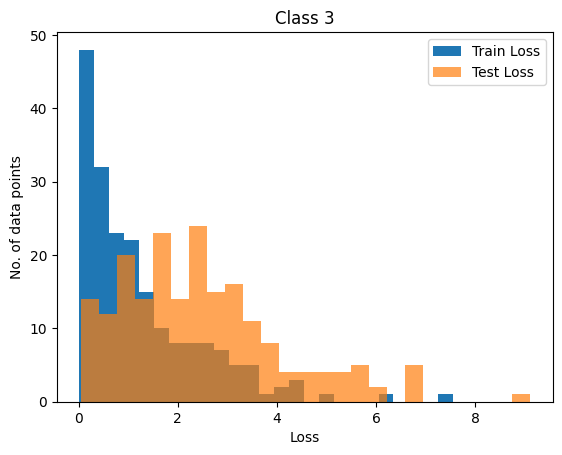

Attack accuracy of the loss membership inference attack for class 3: 0.695


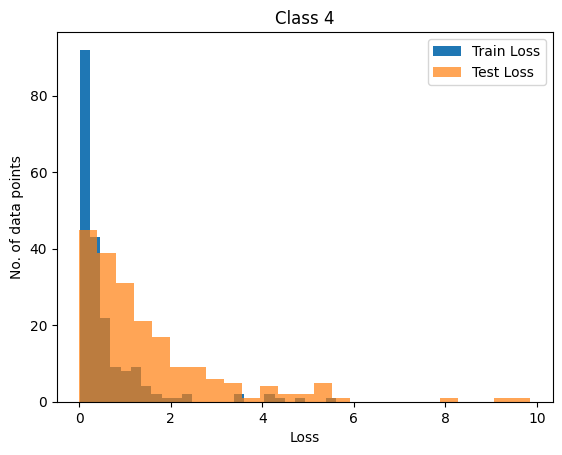

Attack accuracy of the loss membership inference attack for class 4: 0.705


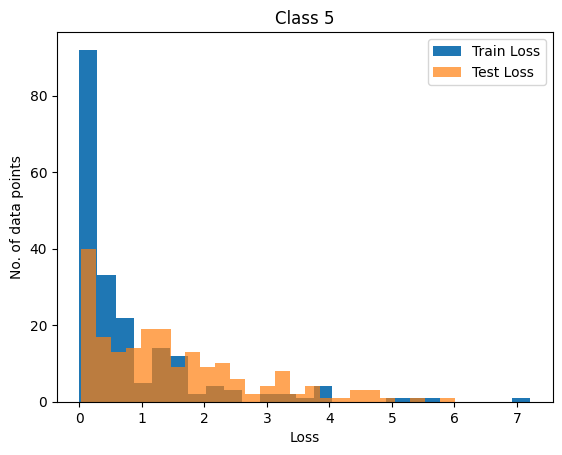

Attack accuracy of the loss membership inference attack for class 5: 0.67


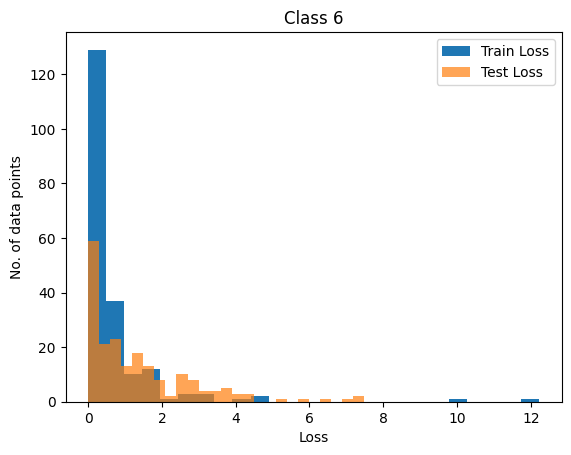

Attack accuracy of the loss membership inference attack for class 6: 0.6475


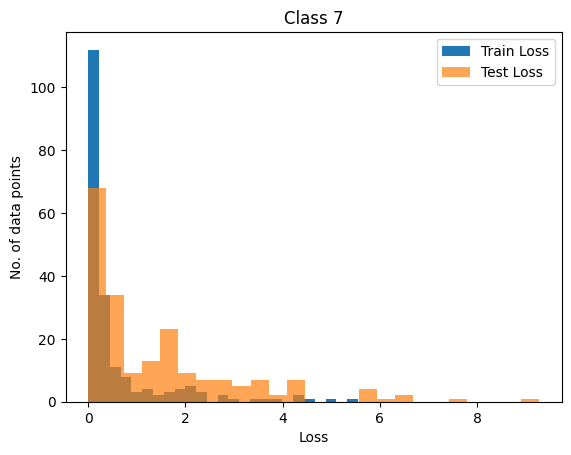

Attack accuracy of the loss membership inference attack for class 7: 0.6775


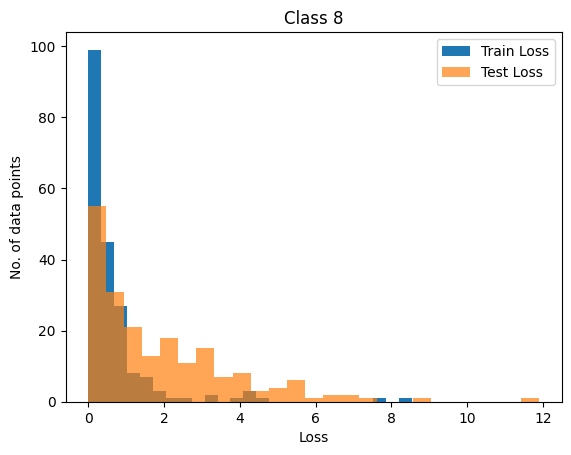

Attack accuracy of the loss membership inference attack for class 8: 0.71


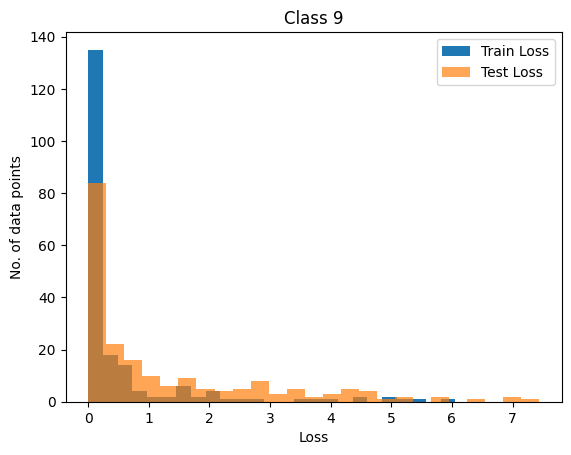

Attack accuracy of the loss membership inference attack for class 9: 0.66
Attack accuracy of the overall per-class loss membership inference attack: 0.685
[0.4, 1.1, 1.0, 1.5, 0.6000000000000001, 0.8, 0.4, 0.5, 0.8, 0.2]


In [36]:
def per_class_loss_membership_inference_attack(model, loss_obj, x_train, y_train, x_test, y_test):
    num_classes = y_train.shape[1]

    # bucket x_train by label
    x_train_buckets = []
    y_train_buckets = []
    for i in range(num_classes):
        # TODO: bucket the train dataset according to class labels
        print(f"Bucketing class {i}...")
        bucket_xi = []
        bucket_yi = []
        for x, y in zip(x_train, y_train):
          if np.argmax(y) == i:
            bucket_xi.append(x)
            bucket_yi.append(y)

        x_train_buckets.append(bucket_xi)
        y_train_buckets.append(bucket_yi)

    # bucket x_test by label
    x_test_buckets = []
    y_test_buckets = []
    for i in range(num_classes):
        # TODO: bucket the test dataset according to class labels
        print(f"Bucketing class {i}...")
        bucket_xi = []
        bucket_yi = []
        for x, y in zip(x_test, y_test):
          if np.argmax(y) == i:
            bucket_xi.append(x)
            bucket_yi.append(y)

        x_test_buckets.append(bucket_xi)
        y_test_buckets.append(bucket_yi)

    # estimate per-class thresholds and report per-class attack accuracy
    loss_thresholds = []
    for i in range(num_classes):
        train_i_logits = model(np.array(x_train_buckets[i]))
        train_i_losses = loss_obj(y_true=y_train_buckets[i], y_pred=train_i_logits)

        test_i_logits = model(np.array(x_test_buckets[i]))
        test_i_losses = loss_obj(y_true=y_test_buckets[i], y_pred=test_i_logits)

        # TODO: plot the loss histogram for the current class
        plot_loss_histogram(train_i_losses, test_i_losses, caption=f'Class {i}')

        # TODO: estimate the loss threshold for the current class
        thresholds = [0.1*x for x in range(1, 51)]
        loss_threshold_i = estimate_threshold(
            train_i_losses,
            test_i_losses,
            thresholds,
            y_train_buckets[i],
            y_test_buckets[i]
          )
        loss_thresholds.append(loss_threshold_i)

        # TODO: generate the membership labels on the train data for the current class
        pred_members_i = [1 if t < loss_threshold_i else 0 for t in train_i_losses]

        # TODO: generate the membership labels on the test data for the current class
        pred_non_members_i = [1 if t < loss_threshold_i else 0 for t in test_i_losses]

        y_pred_i = pred_members_i
        y_pred_i.extend(pred_non_members_i)

        y_true_i = generate_true_membership_labels(y_train_buckets[i], y_test_buckets[i])

        tn_i, fp_i, fn_i, tp_i = confusion_matrix(y_true_i, y_pred_i).ravel()
        print(f"Attack accuracy of the loss membership inference attack for class {i}: {(tp_i + tn_i)/(tn_i + fp_i + fn_i + tp_i)}")

    # compute overall attack accuracy
    train_logits = model(x_train)
    train_losses = loss_obj(y_true=y_train, y_pred=train_logits)

    test_logits = model(x_test)
    test_losses = loss_obj(y_true=y_test, y_pred=test_logits)

    # TODO: generate the membership labels on the train data
    pred_members = []
    for i, tl in enumerate(train_losses):
      label = np.argmax(y_train[i])
      threshold = loss_thresholds[label]
      if tl < threshold:
        pred_members.append(1)
      else:
        pred_members.append(0)

    # TODO: generate the membership labels on the test data
    pred_non_members = []
    for i, tl in enumerate(test_losses):
      label = np.argmax(y_test[i])
      threshold = loss_thresholds[label]
      if tl < threshold:
        pred_non_members.append(1)
      else:
        pred_non_members.append(0)

    y_pred = pred_members
    y_pred.extend(pred_non_members)

    y_true = generate_true_membership_labels(y_train, y_test)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    print(f"Attack accuracy of the overall per-class loss membership inference attack: {(tp + tn)/(tn + fp + fn + tp)}")
    print(loss_thresholds)

loss_obj = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE, from_logits=False)
per_class_loss_membership_inference_attack(model, loss_obj, x_train, y_train, x_test, y_test)

### 2.3. Attacking a Model Trained With Regularization

In [30]:
# TODO: modify the function below to add regularization to the CNN classifier's convolution and dense layers
def regularized_cnn_classifier(input_shape, num_classes, regularizer):
    model = tf.keras.models.Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizer))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizer))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax', kernel_regularizer=regularizer))
    return model

In [31]:
loss_fn = 'categorical_crossentropy'

learning_rate = 0.1
optim_fn = tf.keras.optimizers.SGD(learning_rate)

batch_size = 64
epochs = 50
validation_split = 0.25
hyperparams = HyperParams(loss_fn, optim_fn, batch_size, epochs, validation_split)
regularizer = tf.keras.regularizers.L2(0.01)

regularized_model = regularized_cnn_classifier(cifar10dataset.input_shape, cifar10dataset.num_classes, regularizer)
regularized_model, regularized_history = get_trained_model_on_cifar10(regularized_model, x_train, y_train, hyperparams)

Epoch 1/50
24/24 [==============================] - 3s 96ms/step - loss: 2.9404 - accuracy: 0.1180 - val_loss: 2.8920 - val_accuracy: 0.0900
Epoch 2/50
24/24 [==============================] - 2s 69ms/step - loss: 2.8412 - accuracy: 0.1520 - val_loss: 2.7758 - val_accuracy: 0.1700
Epoch 3/50
24/24 [==============================] - 2s 90ms/step - loss: 2.7565 - accuracy: 0.1720 - val_loss: 2.8227 - val_accuracy: 0.1420
Epoch 4/50
24/24 [==============================] - 2s 69ms/step - loss: 2.6761 - accuracy: 0.1973 - val_loss: 2.6248 - val_accuracy: 0.2260
Epoch 5/50
24/24 [==============================] - 2s 76ms/step - loss: 2.5989 - accuracy: 0.2180 - val_loss: 2.8334 - val_accuracy: 0.1480
Epoch 6/50
24/24 [==============================] - 2s 73ms/step - loss: 2.5329 - accuracy: 0.2427 - val_loss: 2.5289 - val_accuracy: 0.2220
Epoch 7/50
24/24 [==============================] - 3s 113ms/step - loss: 2.5089 - accuracy: 0.2427 - val_loss: 2.4443 - val_accuracy: 0.2700
Epoch 8/50
2

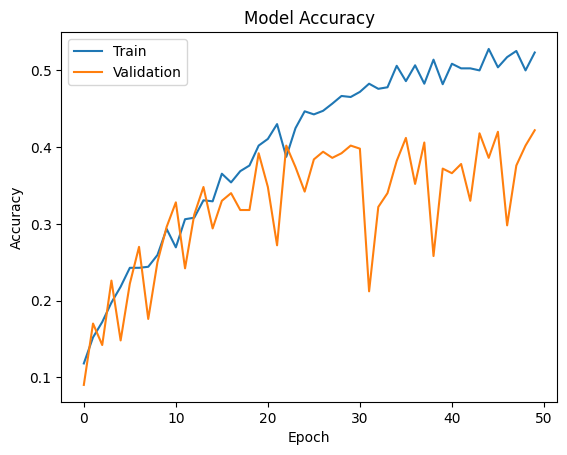

In [32]:
# Plot train and validation accuracy per epoch
plt.plot(regularized_history.history['accuracy'])
plt.plot(regularized_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

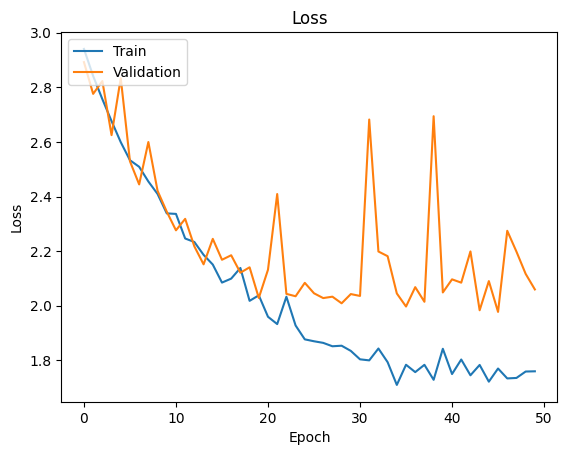

In [33]:
# Plot train and validation loss per epoch
plt.plot(regularized_history.history['loss'])
plt.plot(regularized_history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [34]:
# Evaluate regularized model on train and test data
train_loss, train_acc = regularized_model.evaluate(x_train, y_train)
print(f"Loss on train set: {train_loss}")
print(f"Accuracy on train set: {train_acc}")

test_loss, test_acc = regularized_model.evaluate(x_test, y_test)
print(f"Loss on test set: {test_loss}")
print(f"Accuracy on test set: {test_acc}")

63/63 [==============================] - 1s 10ms/step - loss: 1.6981 - accuracy: 0.5445
Loss on train set: 1.6981098651885986
Accuracy on train set: 0.5444999933242798
63/63 [==============================] - 1s 11ms/step - loss: 2.0630 - accuracy: 0.4035
Loss on test set: 2.0630109310150146
Accuracy on test set: 0.4034999907016754


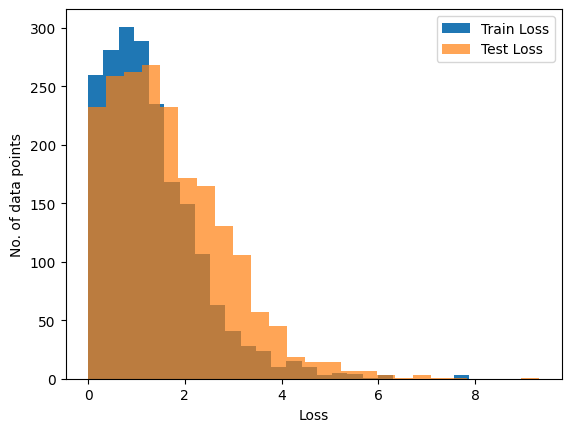

Attack accuracy of the loss membership inference attack: 0.5735 with loss threshold: 1.5
Bucketing class 0...
Bucketing class 1...
Bucketing class 2...
Bucketing class 3...
Bucketing class 4...
Bucketing class 5...
Bucketing class 6...
Bucketing class 7...
Bucketing class 8...
Bucketing class 9...
Bucketing class 0...
Bucketing class 1...
Bucketing class 2...
Bucketing class 3...
Bucketing class 4...
Bucketing class 5...
Bucketing class 6...
Bucketing class 7...
Bucketing class 8...
Bucketing class 9...
Attack accuracy of the loss membership inference attack for class 0: 0.5525
Attack accuracy of the loss membership inference attack for class 1: 0.6175


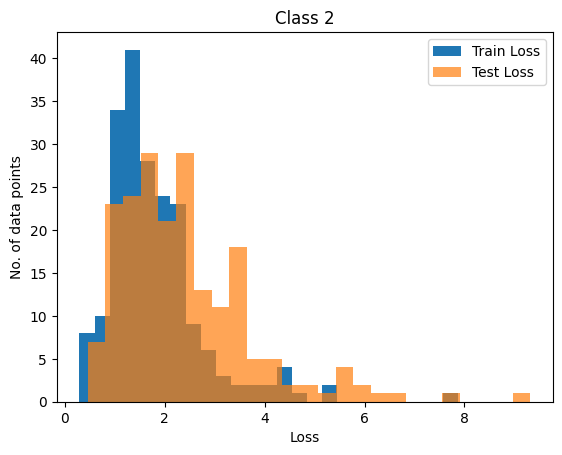

Attack accuracy of the loss membership inference attack for class 2: 0.625


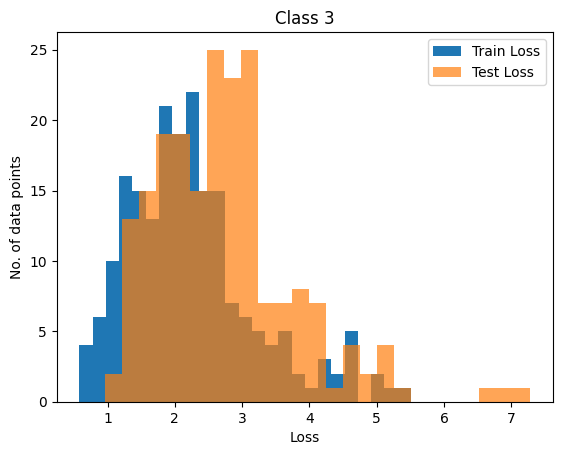

Attack accuracy of the loss membership inference attack for class 3: 0.6325
Attack accuracy of the loss membership inference attack for class 4: 0.6225
Attack accuracy of the loss membership inference attack for class 5: 0.56
Attack accuracy of the loss membership inference attack for class 6: 0.565
Attack accuracy of the loss membership inference attack for class 7: 0.575
Attack accuracy of the loss membership inference attack for class 8: 0.6275
Attack accuracy of the loss membership inference attack for class 9: 0.59
Attack accuracy of the overall per-class loss membership inference attack: 0.59675
[0.30000000000000004, 1.5, 2.4000000000000004, 2.5, 1.3, 1.1, 1.0, 2.3000000000000003, 1.4000000000000001, 0.7000000000000001]


In [35]:
# Perform membership inference attacks on the regularized model
loss_obj = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE, from_logits=False)
loss_membership_inference_attack(regularized_model, loss_obj, x_train, y_train, x_test, y_test)
per_class_loss_membership_inference_attack(regularized_model, loss_obj, x_train, y_train, x_test, y_test)

## 3. Attacking the MLaaS Setting

### 3.1. Designing an Attacker for the MLaaS Setting

In [13]:
def challenge_membership_inference_attack(x_eval_logits, y_eval, x_other, y_other):
    """
    Implements a membership inference attack against the challenge model and
    returns the predicted membership labels on the evaluation dataset.
    Args
        x_eval_logits: Logits returned by the challenge model on x_eval.
        y_eval: True labels corresponding to x_eval_logits.
        x_other, y_other: Subset of the CIFAR10 dataset for your membership inference attack.
    """

    # TODO: generate membership label predictions for the evaluation dataset.
    def get_shadow_model(input_shape, num_classes):
      model = tf.keras.models.Sequential()
      model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
      model.add(MaxPool2D(pool_size=(2, 2)))

      model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
      model.add(MaxPool2D(pool_size=(2, 2)))

      model.add(Flatten())
      model.add(Dropout(0.5))
      model.add(Dense(num_classes, activation='softmax'))

      return model

    def get_attack_model(num_classes):
      model = tf.keras.models.Sequential()
      model.add(tf.keras.Input(shape=(num_classes+1,)))
      model.add(tf.keras.layers.Dense(128, activation='relu'))
      model.add(tf.keras.layers.Dense(64, activation='relu'))
      model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
      return model


    # Create shadow models
    num_classes = 10
    input_shape = x_other[0].shape

    x_train_i = []
    y_train_i = []

    x_test_i = []
    y_test_i = []

    shadow_models = []
    for i in range(num_classes):
      indices = np.random.choice(len(y_other), 2000)
      indices_train = indices[: len(indices) // 2]
      indices_test = indices[ len(indices) // 2 : ]
      x_train_i.append(x_other[indices_train])
      y_train_i.append(y_other[indices_train])

      x_test_i.append(x_other[indices_test])
      y_test_i.append(y_other[indices_test])

      shadow_models.append(get_shadow_model(input_shape, num_classes))

    # Train shadow models
    batch_size = 16
    epochs = 50
    validation_split = 0.1

    attack_model_x = []
    attack_model_y = []

    for i, model in enumerate(shadow_models):
      print(f"Training {i}th shadow model")
      x_train, y_train, x_test, y_test = x_train_i[i], y_train_i[i], x_test_i[i], y_test_i[i]

      model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
      model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split, verbose=2)

      x_train_logits = model(x_train)
      in_labels = np.ones(shape=(x_train_logits.shape[0], 1))
      class_labels = np.argmax(y_train, axis=1)
      attack_model_x.append(np.insert(x_train_logits, 0, class_labels, axis=1))
      attack_model_y.append(in_labels)

      x_test_logits = model(x_test)
      out_labels = np.zeros(shape=(x_train_logits.shape[0], 1))
      class_labels = np.argmax(y_test, axis=1)
      attack_model_x.append(np.insert(x_test_logits, 0, class_labels, axis=1))
      attack_model_y.append(out_labels)

    # Train attack model
    print("Training attack model")
    attack_model_x = np.array(attack_model_x)
    attack_model_x = attack_model_x.reshape(-1, attack_model_x.shape[-1])

    attack_model_y = np.array(attack_model_y)
    attack_model_y = attack_model_y.reshape(-1, attack_model_y.shape[-1])

    attack_model = get_attack_model(num_classes)
    attack_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    attack_model.fit(attack_model_x, attack_model_y, batch_size=128, epochs=100, validation_split=0.2, verbose=2)

    # Inference on attack model
    print("Inferencing membership")
    eval_data = np.insert(x_eval_logits, 0, np.argmax(y_eval, axis=1), axis=1)
    p = attack_model.predict(eval_data)
    predictions = np.where(p < 0.5, 0, 1)
    predictions = tf.squeeze(predictions).numpy()

    return predictions

data_filepath = "attacking_mlaas_data.npz"
with np.load(data_filepath, allow_pickle=True) as data:
    x_eval_logits = data['x_eval_logits'][()]
    y_eval = data['y_eval'][()]
    x_other = data['x_other'][()]
    y_other = data['y_other'][()]

predictions = challenge_membership_inference_attack(x_eval_logits, y_eval, x_other, y_other)

Training 0th shadow model
Epoch 1/50
57/57 - 2s - loss: 2.3042 - accuracy: 0.1300 - val_loss: 2.1967 - val_accuracy: 0.1600 - 2s/epoch - 39ms/step
Epoch 2/50
57/57 - 0s - loss: 2.1054 - accuracy: 0.2300 - val_loss: 1.9451 - val_accuracy: 0.2300 - 237ms/epoch - 4ms/step
Epoch 3/50
57/57 - 0s - loss: 1.9310 - accuracy: 0.3289 - val_loss: 1.9200 - val_accuracy: 0.3200 - 246ms/epoch - 4ms/step
Epoch 4/50
57/57 - 0s - loss: 1.7148 - accuracy: 0.4067 - val_loss: 1.7597 - val_accuracy: 0.3500 - 228ms/epoch - 4ms/step
Epoch 5/50
57/57 - 0s - loss: 1.6179 - accuracy: 0.4378 - val_loss: 1.7864 - val_accuracy: 0.3000 - 233ms/epoch - 4ms/step
Epoch 6/50
57/57 - 0s - loss: 1.5646 - accuracy: 0.4544 - val_loss: 1.7392 - val_accuracy: 0.3700 - 240ms/epoch - 4ms/step
Epoch 7/50
57/57 - 0s - loss: 1.4218 - accuracy: 0.5044 - val_loss: 1.6896 - val_accuracy: 0.3900 - 245ms/epoch - 4ms/step
Epoch 8/50
57/57 - 0s - loss: 1.3147 - accuracy: 0.5500 - val_loss: 1.7208 - val_accuracy: 0.3700 - 246ms/epoch - 4

## 4. Testing Unintended Memorization

### 4.1. Assessing a CNN Classifier on CIFAR10

In [46]:
def check_memorization_for_point(x_point, y_point):
    # TODO: create two datasets, one with (x_point, y_point) and one without
    idx = [i for i, t in enumerate(x_train) if (t == x_point).all()][0]
    x_train_without, y_train_without = np.delete(x_train, idx, axis=0), np.delete(y_train, idx, axis=0)
    x_train_with, y_train_with = x_train, y_train
    assert len(x_train) == len(x_train_without) + 1

    # hyperparameters to train the two models
    loss_fn = 'categorical_crossentropy'

    learning_rate = 0.1
    optim_fn = tf.keras.optimizers.legacy.SGD(learning_rate)

    batch_size = 64
    epochs = 10
    validation_split = 0.25
    hyperparams = HyperParams(loss_fn, optim_fn, batch_size, epochs, validation_split)

    # initialize two models
    model_with = cnn_classifier(cifar10dataset.input_shape, cifar10dataset.num_classes)
    model_without = cnn_classifier(cifar10dataset.input_shape, cifar10dataset.num_classes)

    # train two models
    print("Training model with point...")
    model_with, history_with = get_trained_model_on_cifar10(model_with, x_train_with, y_train_with, hyperparams)
    print("Training model without point...")
    model_without, history_without = get_trained_model_on_cifar10(model_without, x_train_without, y_train_without, hyperparams)

    # TODO: compute predictions of the two models on the chosen point
    pred_with = model_with.predict(tf.expand_dims(x_point, axis=0)).squeeze()
    pred_without = model_without.predict(tf.expand_dims(x_point, axis=0)).squeeze()

    # TODO: compute memorization value of the chosen point using the predictions
    label = np.argmax(y_point)
    memorization = np.abs(pred_with[label] - pred_without[label])
    print(f"Memorization value for point: {memorization}")

    # TODO: compute loss of the two models on the chosen point
    loss_obj = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)
    loss_with = loss_obj(y_point, pred_with)
    print(f"Loss of model trained with point on (x_point, y_point): {loss_with}")
    print(f"Label with point on (x_point, y_point): {np.argmax(pred_with)}")

    loss_without = loss_obj(y_point, pred_without)
    print(f"Loss of model trained without point on (x_point, y_point): {loss_without}")
    print(f"Label without point on (x_point, y_point): {np.argmax(pred_without)}")


x_point = x_train[100]
y_point = y_train[100]
check_memorization_for_point(x_point, y_point)

# UNCOMMENT THE FOLLOWING SECTION FOR MULTIPLE IMAGES
# indices = np.random.choice(len(x_train), 50)
# for i in indices:
#   x_point = x_train[i]
#   y_point = y_train[i]
#   check_memorization_for_point(x_point, y_point)
#   print("\n\n")

Training model with point...
Epoch 1/10
24/24 [==============================] - 1s 19ms/step - loss: 2.3077 - accuracy: 0.0867 - val_loss: 2.2926 - val_accuracy: 0.1220
Epoch 2/10
24/24 [==============================] - 0s 8ms/step - loss: 2.2747 - accuracy: 0.1407 - val_loss: 2.2572 - val_accuracy: 0.1540
Epoch 3/10
24/24 [==============================] - 0s 8ms/step - loss: 2.2198 - accuracy: 0.1660 - val_loss: 2.1794 - val_accuracy: 0.1900
Epoch 4/10
24/24 [==============================] - 0s 8ms/step - loss: 2.1990 - accuracy: 0.1673 - val_loss: 2.1237 - val_accuracy: 0.2520
Epoch 5/10
24/24 [==============================] - 0s 8ms/step - loss: 2.1466 - accuracy: 0.2027 - val_loss: 2.2129 - val_accuracy: 0.1600
Epoch 6/10
24/24 [==============================] - 0s 8ms/step - loss: 2.0977 - accuracy: 0.2420 - val_loss: 2.1246 - val_accuracy: 0.2000
Epoch 7/10
24/24 [==============================] - 0s 8ms/step - loss: 2.0868 - accuracy: 0.2347 - val_loss: 2.0698 - val_accurac

### 4.2. Assessing an LSTM Next Character Predictor on Shakespeare Dataset

In [3]:
from tensorflow.keras.layers.experimental import preprocessing

class ShakespeareDataset:
    def __init__(self, num_train_data):
        dataset_filepath = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

        text = open(dataset_filepath, 'rb').read().decode(encoding='utf-8')
        print(f'Length of text: {len(text)} characters')

        self.vocab = sorted(set(text))
        print(f'{len(self.vocab)} unique characters')

        self.ids_from_chars = preprocessing.StringLookup(
            vocabulary=list(self.vocab),
            mask_token=None
        )

        self.chars_from_ids = preprocessing.StringLookup(
            vocabulary=self.ids_from_chars.get_vocabulary(),
            invert=True,
            mask_token=None)

        self.ids = self.ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))[:num_train_data]
        print(f'Length of ids: {len(self.ids)} ids')

    def ids_from_text(self, text):
        chars = tf.strings.unicode_split(text, 'UTF-8')
        return self.ids_from_chars(chars)

    def text_from_ids(self, ids):
        return tf.strings.reduce_join(self.chars_from_ids(ids), axis=-1)

    def split_input_target(self, sequence):
        input_text = sequence[:-1]
        target_text = sequence[1:]
        return input_text, target_text

    def get_dataset(self, sequence_length):
        ds = tf.data.Dataset.from_tensor_slices(self.ids)
        sequences = ds.batch(sequence_length + 1, drop_remainder=True)
        dataset = sequences.map(self.split_input_target)
        return dataset

    def get_augmented_dataset_with_canaries(self, sequence_length, canaries, ks):
        # TODO: replace the line below and add canary ids to the new_ids
        new_ids = np.array([[self.ids_from_text(c) for c in canaries] * k for k in ks]).flatten()
        new_ids = tf.concat([self.ids, new_ids], axis=0)

        ds = tf.data.Dataset.from_tensor_slices(new_ids)
        sequences = ds.batch(sequence_length + 1, drop_remainder=True)
        dataset = sequences.map(self.split_input_target)
        return dataset

In [4]:
class LstmCharGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, lstm_units):
        super().__init__(self)
        self.embedding = tf.keras.layers.Embedding(vocab_size,
                                                   embedding_dim)
        self.lstm = tf.keras.layers.LSTM(units=lstm_units,
                                         return_sequences=True,
                                         return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, state_h=None, state_c=None, return_state=False, training=False):
        x = inputs
        x = self.embedding(x, training=training)
        if state_h is None and state_c is None:
            state_h, state_c = self.lstm.get_initial_state(x)
        x, state_h, state_c = self.lstm(x, initial_state=[state_h, state_c],
                                        training=training)
        x = self.dense(x, training=training)

        if return_state:
            return x, state_h, state_c
        else:
            return x

In [9]:
def perplexity(y_true, y_pred):
    # TODO: compute the perplexity of a sequence
    # using y_true (target sequence) and y_pred (predicted sequence).

    perplexity = 0.0
    for i, row in enumerate(y_pred):
      perplexity += -np.log2(row[y_true[i]])

    return perplexity

In [10]:
def check_memorization_for_canary(sequence_length, canary, k):
    shakespeare_dataset = ShakespeareDataset(num_train_data=150000)
    batch_size = 64
    buffer_size = 10000

    # TODO: create two datasets, one with the canary and one without
    train_dataset = shakespeare_dataset.get_dataset(sequence_length)
    augmented_train_dataset = shakespeare_dataset.get_augmented_dataset_with_canaries(sequence_length, [canary], [k])

    # batch data
    train_dataset = (
        train_dataset
        .shuffle(buffer_size)
        .batch(batch_size, drop_remainder=True)
        .prefetch(tf.data.experimental.AUTOTUNE)
    )
    augmented_train_dataset = (
        augmented_train_dataset
        .shuffle(buffer_size)
        .batch(batch_size, drop_remainder=True)
        .prefetch(tf.data.experimental.AUTOTUNE)
    )

    # hyperparameters
    vocab_size = len(shakespeare_dataset.vocab)
    embedding_dim = 256
    lstm_units = 400
    loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
    optimizer_fn = 'adam'
    epochs = 10

    # initialize two models
    lstm_char_gen_model_with = LstmCharGenerator(
        vocab_size = len(shakespeare_dataset.ids_from_chars.get_vocabulary()),
        embedding_dim=embedding_dim,
        lstm_units=lstm_units
    )

    lstm_char_gen_model_without = LstmCharGenerator(
        vocab_size = len(shakespeare_dataset.ids_from_chars.get_vocabulary()),
        embedding_dim=embedding_dim,
        lstm_units=lstm_units
    )

    lstm_char_gen_model_with.compile(optimizer=optimizer_fn, loss=loss_fn, metrics=['accuracy'])
    lstm_char_gen_model_without.compile(optimizer=optimizer_fn, loss=loss_fn, metrics=['accuracy'])

    # train two models
    print("Training model with canary...")
    history_with = lstm_char_gen_model_with.fit(augmented_train_dataset, epochs=epochs)
    print("Training model without canary...")
    history_without = lstm_char_gen_model_without.fit(train_dataset, epochs=epochs)

    # TODO: compute perplexities for the canary and the relative diff
    x, y = shakespeare_dataset.split_input_target(canary)
    x = shakespeare_dataset.ids_from_text(x)
    y_true = shakespeare_dataset.ids_from_text(y)

    y_pred = lstm_char_gen_model_with(inputs=np.array([x]))
    perplexity_with = perplexity(y_true, tf.squeeze(tf.nn.softmax(y_pred)).numpy())

    y_pred = lstm_char_gen_model_without(inputs=np.array([x]))
    perplexity_without = perplexity(y_true, tf.squeeze(tf.nn.softmax(y_pred)).numpy())

    perplexity_diff = np.abs(perplexity_with - perplexity_without)
    print(f"Relative perplexity: {perplexity_diff}")


# TODO: create a canary to assess memorization
canary = 'The random sequence is ' + ''.join(np.random.choice([*'ABCDEFGHIJ'], 4)) # canary
k = 10 # number of times to add canary in the dataset

sequence_length = 200
check_memorization_for_canary(sequence_length, canary, k)

Length of text: 1115394 characters
65 unique characters
Length of ids: 150000 ids
Training model with canary...
Epoch 1/10
11/11 [==============================] - 3s 57ms/step - loss: 3.6825 - accuracy: 0.1214
Epoch 2/10
11/11 [==============================] - 1s 37ms/step - loss: 3.3032 - accuracy: 0.1504
Epoch 3/10
11/11 [==============================] - 1s 45ms/step - loss: 3.2435 - accuracy: 0.1487
Epoch 4/10
11/11 [==============================] - 1s 62ms/step - loss: 3.1591 - accuracy: 0.1724
Epoch 5/10
11/11 [==============================] - 1s 38ms/step - loss: 2.9314 - accuracy: 0.2389
Epoch 6/10
11/11 [==============================] - 1s 39ms/step - loss: 2.6734 - accuracy: 0.2913
Epoch 7/10
11/11 [==============================] - 1s 37ms/step - loss: 2.5138 - accuracy: 0.3081
Epoch 8/10
11/11 [==============================] - 1s 37ms/step - loss: 2.4202 - accuracy: 0.3219
Epoch 9/10
11/11 [==============================] - 1s 37ms/step - loss: 2.3471 - accuracy: 0.33

## 5. Input Reconstruction

In [ ]:
import itertools

def generate_all_canaries(prefix, canary_length):
    canaries = []
    for p in itertools.product('ABCDEFGHIJ', repeat=canary_length):
        combination = ''.join(p)
        canaries.append(prefix + combination)
    return canaries

def brute_force_reconstruction(model, dataset, canaries):
    perplexities = []
    for canary in canaries:
        input_seq, target_seq = dataset.split_input_target(canary)
        input_ids = dataset.ids_from_text(input_seq)
        target_ids = dataset.ids_from_text(target_seq)

        input_logits = model(inputs=np.array([input_ids]))
        perplexities.append(perplexity(y_true=target_ids, y_pred=input_logits).numpy())

    ordered_canaries = sorted(zip(canaries, perplexities), key=lambda x: x[1])

    return ordered_canaries

In [ ]:
# Testing brute force reconstruction

sequence_length = 200
prefix = 'The random number is '

canaries_list = [
    "The random sequence is ABCD",
    "The random sequence is EFGH",
    "The random sequence is AIAI",
    "The random sequence is GGGG",
    "The random sequence is EDGE"
]
k_list = [2, 5, 7, 10, 15]
shakespeare_dataset = ShakespeareDataset(num_train_data=150000)
augmented_train_dataset = shakespeare_dataset.get_augmented_dataset_with_canaries(sequence_length,
                                                                                  canaries=canaries_list,
                                                                                  ks=k_list)

batch_size = 64
buffer_size = 10000
augmented_train_dataset = (
    augmented_train_dataset
    .shuffle(buffer_size)
    .batch(batch_size, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

embedding_dim = 256
lstm_units = 400
lstm_char_gen_model = LstmCharGenerator(
    vocab_size = len(shakespeare_dataset.ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    lstm_units=lstm_units
)

loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer_fn = 'adam'
lstm_char_gen_model.compile(optimizer=optimizer_fn, loss=loss_fn, metrics=['accuracy'])
lstm_char_gen_model.fit(augmented_train_dataset, epochs=10)

canary_length = 4
canaries = generate_all_canaries(prefix, canary_length)
ordered_canaries = brute_force_reconstruction(lstm_char_gen_model, shakespeare_dataset, canaries)

print(f"Top 5 candidates for the canaries: {ordered_canaries[:5]}")

In [ ]:
def efficient_reconstruction(model, dataset, k, canary_prefix, canary_length):
    # TODO: return the k most likely sequences
    reconstructed_sequences = []
    return reconstructed_sequences

embedding_dim = 256
lstm_units = 400
shakespeare_dataset = ShakespeareDataset(num_train_data=150000)
input_reconstruction_challenge_model = LstmCharGenerator(
    vocab_size = len(shakespeare_dataset.ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    lstm_units=lstm_units
)

input_reconstruction_challenge_model.load_weights("input_reconstruction_challenge_model/checkpoint")

prefix = ' '
canary_length = 50
k = 5
reconstructed_sequence = efficient_reconstruction(input_reconstruction_challenge_model,
                                                  shakespeare_dataset, k,
                                                  prefix, canary_length)
print(f'Reconstructed input: {reconstructed_sequence}')